# Fuzzing with Constraints

In previous chapters, we have seen how [Grammar-Based Fuzzing](GrammarFuzzer.ipynb) allows us to express the structure of an input using context-free grammars, and how we can use these very grammars to efficiently generate myriads of valid inputs.
However, there are input features that cannot be expressed in a context-free language: "$X$ is the length of $Y$", for instance, or "$X$ is an identifier previously declared".
In this chapter, we show how the *ISLa* framework allows us to express such features as _constraints_ added to a grammar, and how ISLa solves these constraints automatically to produce inputs that are not only _syntactically_ valid, but actually _semantically_ valid.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).
* The chapter on [generators and filters](GeneratorGrammarFuzzer.ipynb) addresses a similar problem, but with program code instead of constraints.

In [2]:
import bookutils

In [3]:
# ignore
import sys

In [4]:
# ignore
if sys.version_info < (3, 10):
    print("This code requires Python 3.10 or later")
    sys.exit(0)

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.FuzzingWithConstraints import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

```python
/Users/zeller/Projects/fuzzingbook/notebooks/ClassDiagram.ipynb:367: UserWarning: ISLaSolver.solve() is listed as public, but has no docstring
  warnings.warn(f"{f.__qualname__}() is listed as public,"
/Users/zeller/Projects/fuzzingbook/notebooks/ClassDiagram.ipynb:440: UserWarning: Class ISLaSolver has no docstring
  warnings.warn(f"Class {cls.__name__} has no docstring")

```
![](PICS/FuzzingWithConstraints-synopsis-1.svg)

* FIXME: Have docstrings for publicly available methods
* FIXME: Have a docstring for the `ISLaSolver` class
* FIXME: How do I check a given string whether it satisfies constraints? (Likely `isla.evaluator.evaluate(constraint, tree, grammar)`)



## Semantic Input Properties

In this book, we have frequently used [grammars](Grammars.ipynb) to [systematically generate inputs](GrammarFuzzer.ipynb) that [cover input structure](GrammarCoverageFuzzer.ipynb) and more.
But while it is relatively easy to express the _syntax_ of an input using a grammar, there are input properties that _cannot_ be expressed using a grammar.
Such input properties are called _semantic_ properties.

Let us illustrate semantic properties using a simple example.
We want to test some system that is configured by two settings, a _page size_ and a _buffer size_. 
Both these come as integer numbers as part of a human-readable configuration file.
The _syntax_ of this file is given by the following grammar:

In [5]:
from Grammars import Grammar, is_valid_grammar, syntax_diagram

In [6]:
import string

In [7]:
CONFIG_GRAMMAR: Grammar = {
    "<start>": ["<config>"],
    "<config>": [
        "pagesize=<pagesize>\n"
        "bufsize=<bufsize>"
    ],
    "<pagesize>": ["<int>"],
    "<bufsize>": ["<int>"],
    "<int>": ["<digit>", "<leaddigit><int>"],
    "<digit>": list("0123456789"),
    "<leaddigit>": list("123456789")
}

In [8]:
assert is_valid_grammar(CONFIG_GRAMMAR)

Here's a visualization of this grammar as a railroad diagram, showing its structure:

start


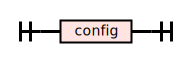

config


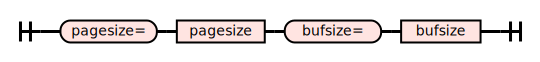

pagesize


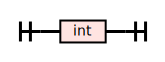

bufsize


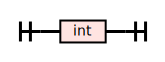

int


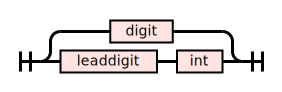

digit


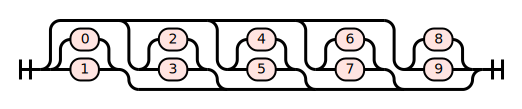

leaddigit


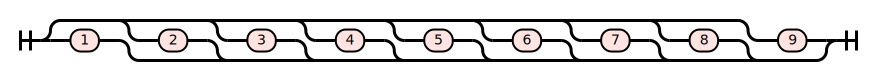

In [9]:
# ignore
syntax_diagram(CONFIG_GRAMMAR)

Using this grammar, we can now use any of our grammar-based fuzzers to generate valid inputs.
For instance:

In [10]:
from GrammarFuzzer import GrammarFuzzer, DerivationTree

In [11]:
fuzzer = GrammarFuzzer(CONFIG_GRAMMAR)

In [12]:
for i in range(10):
    print(i)
    print(fuzzer.fuzz())

0
pagesize=5
bufsize=7
1
pagesize=949
bufsize=1
2
pagesize=3
bufsize=7
3
pagesize=89
bufsize=597
4
pagesize=9
bufsize=0
5
pagesize=35
bufsize=222
6
pagesize=0
bufsize=3
7
pagesize=1
bufsize=58
8
pagesize=351
bufsize=1
9
pagesize=0
bufsize=42


So far, so good - and indeed, these random values will help us test our (hypothetical) system.
But what if we want to _control_ these values further, putting our system to the test?

A grammar gives us _some_ control. If we want to ensure a page size of at least 100,000, for instance, a rule like
```python
"<bufsize>": ["<leaddigit><digit><digit><digit><digit><digit>"]
```
would do the job.
We could also express that the page size should be an odd number, by having it end in an odd digit.
But if we want to state that the page size should be, say, a multiple of 8, or larger or less than the buffer size, we are out of luck.

In the [chapter on fuzzing with generators](GeneratorGrammarFuzzer.ipynb), we have seen how to attach _program code_ to individual rules - program code that would either _generate_ individual elements right away or _filter_ only these that satisfy specific conditions.

Attaching code makes things very flexible, but also has several disadvantages:

* First, it is pretty hard to generate inputs that satisfy multiple constraints at once.
In essence, you have to code your own _strategy_ for generating inputs, which at some point negates the advantage of having an abstract representation such as a grammar.
* Second, your code is not portable. While a grammar can be easily adapted to _any_ grammar-based fuzzer, adding, say, Python code, ties you to the Python environment forever.
* Third, program code can only be used for _producing_ inputs or _checking_ inputs, but not both. This, again, is a downside compared to a pure grammar representation.

Another, very general solution to this problem would be to use _unrestricted_ grammars rather than the _context-free_ grammars we have used so far.
In an unrestricted grammar, one can have multiple symbols also on the left hand side of an expansion rule, making them very flexible.
In fact, they are _Turing-universal_, meaning that they can express any feature that could also be expressed in program code; and they could thus check and produce arbitrary strings with arbitrary features. (If they finish, that is – unrestricted grammars also suffer from the halting problem.)

The downside is that there is literally no programming support for unrestricted grammars – we'd have to implement all of arithmetics, strings, and other functionality from scratch in a grammar, which is - well - not fun.

## Constraints to the Rescue

In recent work, Dominic Steinhöfel and Andreas Zeller (one of the authors of this book) have presented an infrastructure that allows to produce inputs with _arbitrary properties_, but without having to go through the trouble of implementing producers or checkers.
Instead, they suggest a dedicated _language_ for specifiying inputs, named _ISLa_ (for input specification language).
_ISLa_ combines a standard context-free _grammar_ with _constraints_ that express _semantic_ properties of the inputs and their elements.
ISLa can be used as a _fuzzer_ (producing inputs that satisfy the constraints) as well as a _checker_ (checking inputs whether they satisfy the given constraints).

Let us illustrate ISLa by example. ISLa comes as a Python package named `isla-solver` that can be easily installed using `pip`:

```shell
$ pip install isla-solver
```

This also installs all dependent packages (such as `fuzzingbook`, for instance).

The core of ISLa is the _ISLa Solver_ – the component that actually _solves_ constraints to produce satisfying inputs.

In [13]:
import isla  # type: ignore

In [14]:
from isla.language import parse_isla  # type: ignore

In [15]:
from isla.solver import ISLaSolver  # type: ignore

The constructor of an `ISLASolver` takes two mandatory arguments.
* The _grammar_ is the grammar the solver should produce inputs from.
* The _constraint_ is the constraint the produced inputs should satisfy.

To express a constraint, we have a variety of _functions_ and _predicates_ at our disposition.
These can be applied to individual elements of the grammar, notably their nonterminals.
The function `str.len()`, for instance, returns the length of a string.
If we want to have inputs in which the page size has at least 6 digits, we can write:

In [16]:
solver = ISLaSolver(CONFIG_GRAMMAR, 'str.len(<pagesize>) >= 6')

The method `solve()` returns an iterator over all produced strings from the ISLa solver. To get these inputs, we can thus write

In [17]:
for i in range(10):
    print(i)
    print(next(solver.solve()))   

0
pagesize=448880
bufsize=2
1
pagesize=842420
bufsize=99
2
pagesize=848410
bufsize=4
3
pagesize=842210
bufsize=6
4
pagesize=822480
bufsize=2
5
pagesize=824480
bufsize=90
6
pagesize=888420
bufsize=1
7
pagesize=888210
bufsize=81
8
pagesize=822210
bufsize=4
9
pagesize=822280
bufsize=5


... and we see that, indeed, each page size has exactly six digits.

To express a minimum numeric value, however, we can use a more elegant way.
The function `str.to_int()`, for instance, converts a string into an integer.
To obtain a page size that of at least 100000, we can thus also write

In [18]:
solver = ISLaSolver(CONFIG_GRAMMAR, 'str.to.int(<pagesize>) >= 100000')
print(next(solver.solve()))

pagesize=284119
bufsize=10


If we want the page size to be in the range of 100 to 200, we can state this as a logical conjunction (using `and`)

In [19]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                    '''
                    str.to.int(<pagesize>) >= 100 and 
                    str.to.int(<pagesize>) <= 200
                    ''')
print(next(solver.solve()))

pagesize=180
bufsize=31


And if we want the page size to be a multiple of seven, we can write

In [20]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                    '''
                    (= (mod (str.to.int <pagesize>) 7) 0)
                    ''')
print(next(solver.solve()))

Evaluation of expression StrToInt("0")%7 not implemented.
Evaluation of expression StrToInt("7")%7 not implemented.
Evaluation of expression StrToInt("70")%7 not implemented.
Evaluation of expression StrToInt("14")%7 not implemented.
Evaluation of expression StrToInt("28")%7 not implemented.
Evaluation of expression StrToInt("35")%7 not implemented.
Evaluation of expression StrToInt("77")%7 not implemented.
Evaluation of expression StrToInt("56")%7 not implemented.
Evaluation of expression StrToInt("84")%7 not implemented.
Evaluation of expression StrToInt("21")%7 not implemented.


pagesize=0
bufsize=0


* FIXME: How do I write this in infix syntax?
* FIXME: Suppress warnings unless relevant for the user

ISLa constraints can also involve multiple elements. Expressing equality between two elements is easy:

In [21]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                    '''
                    <pagesize> = <bufsize>
                    ''')
print(next(solver.solve()))

pagesize=0
bufsize=0


We can also use numerical constraints, stating that the buffer size should always be exactly one more than the page size:

In [22]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                    '''
                    str.to.int(<pagesize>) > 1024 and
                    str.to.int(<bufsize>) = str.to.int(<pagesize>) + 1
                    ''')
print(next(solver.solve()))

pagesize=1810
bufsize=1811


All the above functions (like `str.to.int`) actually stem from the _SMT-LIB_ library for _satisfiability modulo theories_ (SMT), a standard for expressing constraints for constraint solvers (like ISLa).
The [list of all theories defined in SMT-LIB](https://smtlib.cs.uiowa.edu/theories.shtml) lists dozens of functions and predicates that can be used in ISLa constraints.

### Excursion: Using SMT-LIB Syntax

Instead of the above "infix" syntax which is familiar to programmers, ISLa also supports full SMT-LIB syntax.
Instead of writing $f(x_1, x_2, x_3, \dots)$ for a function $f$ and its arguments $x_1 \dots x_n$, SMT-LIB uses a "prefix" LISP-like syntax in which all functions and operators are written as $(f x_1 x_2 x_3 \dots)$.
The above predicate would thus be written as

In [23]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                '''
                (> (str.to.int <pagesize>) 1024)
                and
                (= (str.to.int <bufsize>) (+ (str.to.int <pagesize>) 1))
                ''')
print(next(solver.solve()))

pagesize=5819
bufsize=5820


Note that for boolean operators such as `and`, we still use the ISLa infix syntax; having ISLa handle these operators is more efficient than passing them on to the constraint solver.

* FIXME: Support `and` as part of SMT-LIB expressions

### End of Excursion

## Accessing Elements

So far, we have accessed nonterminals simply by referencing their name, as in `<bufsize>` or `<pagesize>`.
However, in some cases, this simple method is not sufficient.
In our configuration grammar, for instance, we may want to access (or constrain) `<int>` elements.
However, we do not want to constrain _all_ integers at once, but only those in a particular _context_ – say, those that occur as a part of a `<pagesize>` element, or only those that occur as part of a `<config>` element.

To this end, ISLa allows to reference _parts_ of a given element, using two special operators.

The expression `<a>.<b>` refers to the _immediate_ subpart `<b>` of some element `<a>`.
That is, `<b>` has to appear in one of the expansion rules of `<a>`.
For instance, `<pagesize>.<int>` refers to the `<int>` element of a page size.
Here is an example using the dot operator:

In [24]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
                '''
                <pagesize>.<int> = <bufsize>.<int>
                ''')
print(next(solver.solve()))

pagesize=0
bufsize=0


The expression `<a>..<b>`, however, refers to _any_ subpart `<b>` of some element `<a>`. That is, `<b>` can appear in the expansion of `<a>`, but also in the expansion of any subelement (and any subelement thereof).
Here is an example using the double dot operator, enforcing _every_ digit in a `<config>` element to be `7`:

In [25]:
from ExpectError import ExpectError

In [26]:
with ExpectError():
    solver = ISLaSolver(CONFIG_GRAMMAR, 
                '''
                <config>..<digit> = "7"
                ''')
    print(next(solver.solve()))

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_82265/2177507368.py", line 2, in <module>
    solver = ISLaSolver(CONFIG_GRAMMAR,
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 236, in __init__
    formula = parse_isla(formula, grammar, structural_predicates, semantic_predicates)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/language.py", line 2693, in parse_isla
    antlr4.ParseTreeWalker().walk(isla_emitter, parser.start())
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 161, in walk
    self.exitRule(listener, t)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 188, in exitRule
    ctx.exitRule(listener)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/isla_language/IslaLanguageParser.py", line 202, in exitRule
    l

To reason about dots and double dots, it helps visualizing the string in question as a _derivation tree_ discussed in the [chapter on grammar-based fuzzing](GrammarFuzzer.ipynb).
The derivation tree of the input 
```
pagesize=12
bufsize=34
```
for instance, looks like this:

In [27]:
# ignore
from Parser import EarleyParser
from GrammarFuzzer import display_tree

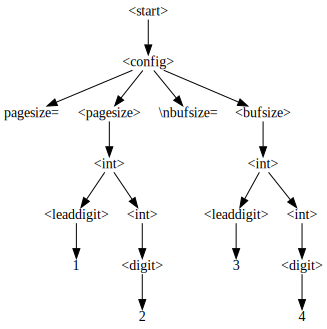

In [28]:
# ignore
inp = 'pagesize=12\nbufsize=34'
parser = EarleyParser(CONFIG_GRAMMAR)
tree = next(parser.parse(inp))
display_tree(tree)

In this tree, the `.` syntax refers to _immediate_ children. `<bufsize>.<int>` is the one `<int>` node that is the immediate descendant of `<bufsize>` (but not any other `<int>` node).
In contrast, `<config>..<digit>` refers to _all_ `<digit>` descendants of the `<config>` node.

If an element has multiple children of the same type, one can use the special `<a>[$n$]` syntax to access the $n$-th child of type `<a>`. (Note that to access the first child, $n$ is equal to one, not zero.) If, for whatever reason, we wanted to ensure that the second `<digit>` in our `<int>` elements is 7, we can enforce this with

In [29]:
with ExpectError():
    solver = ISLaSolver(CONFIG_GRAMMAR, 
                '''
                <int>.<digit>[2] = "7"
                ''')
    print(next(solver.solve()))

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_82265/3992921923.py", line 2, in <module>
    solver = ISLaSolver(CONFIG_GRAMMAR,
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/solver.py", line 236, in __init__
    formula = parse_isla(formula, grammar, structural_predicates, semantic_predicates)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/isla/language.py", line 2693, in parse_isla
    antlr4.ParseTreeWalker().walk(isla_emitter, parser.start())
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 160, in walk
    self.walk(listener, child)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 160, in walk
    self.walk(listener, child)
  File "/Users/zeller/.pyenv/versions/3.10.2/lib/python3.10/site-packages/antlr4/tree/Tree.py", line 160, in walk
    self.walk(listener, child)

Note that `<digit>[2]` is actually the _third_ digit in our integers; the first digit is the `<leaddigit>`, followed by `<digit>[1]`, and then `<digit>[2]`.

* FIXME: Is there more support for XPath-like selectors? If so, we should have an excursion for them

## Quantifiers

By default, all nonterminals in ISLa constraints are _universally_ quantified - that is, any constraint applying to, say, some `<int>` element applies to _all_ `<int>` elements in the resulting string.
If you only want to constrain _one_ element, though, you have to (and can) specify this in ISLa, using an _existential quantifier_.

To use an existential quantifier in ISLa, use the construct
```
exists TYPE VARIABLE in CONTEXT: (CONSTRAINT)
```
where `VARIABLE` is some identifier, `TYPE` is its type (as a nonterminal), and `CONTEXT` is the context (again a nonterminal) in which the constraint should hold.
`CONSTRAINT` is again a constraint expression, in which you now can make use of `VARIABLE` as the element whose existence you assume.

Let us illustrate existential quantification again using a simple example.
We want to make sure that at least one integer in our generated string has a value of more than 1000.
So we write

In [30]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            exists <int> i in <start>:
                (str.to.int(i) > 1000)
            ''')
for i in range(10):
    print(i)
    print(next(solver.solve()))

0
pagesize=4840
bufsize=14
1
pagesize=8780
bufsize=5
2
pagesize=8130
bufsize=54
3
pagesize=2940
bufsize=7
4
pagesize=2910
bufsize=1
5
pagesize=2254
bufsize=66
6
pagesize=8829
bufsize=9
7
pagesize=2948
bufsize=9
8
pagesize=8720
bufsize=1
9
pagesize=2928
bufsize=95


We note that all generated inputs satisfy the constraint of having at least one integer that satisfies the constraint.

Besides existential quantification, there also is _universal_ quantification, using the `forall` keyword instead of `exists`.
If we want _all_ elements in some context to satisfy a constraint, this comes in handy.

In [31]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            forall <int> i in <start>:
                (str.to.int(i) > 1000)
            ''')
print(next(solver.solve()))

pagesize=4110
bufsize=4910


We see that all `<int>` elements satisfy the constraint.

By default, all nonterminals that re used directly in constraints are universally quantified within the `<start>` symbol, so the above can actually be simplified to

In [32]:
solver = ISLaSolver(CONFIG_GRAMMAR, 
            '''
            str.to.int(<int>) > 1000
            ''')
print(next(solver.solve()))

pagesize=4210
bufsize=2449


... and you realize that in all our initial constraints, we always had an implicit universal quantification.

* FIXME: The above `forall` iterators return only one solution. Why?

## Checking Inputs

Using an `ISLaSolver`, we can also check if an input satisfies the constraints.
Let us check if in a given input, `<pagesize>` and `<bufsize>` are the same.

In [33]:
constraint = '<pagesize> = <bufsize>'
solver = ISLaSolver(CONFIG_GRAMMAR, constraint)

First, we need to parse the input into a derivation tree. This is done using the `parse()` method.
Note that this does not yet check the constraint; it will, however, detect if the given string does not conform to the grammar.

In [34]:
tree = solver.parse('<config>', 'pagesize=12\nbufsize=34')

* FIXME: The `nonterminal` should be an optional second parameter, and default to `<start>`
* FIXME: Using `<start>` as `nonterminal` always fails

To check the tree, we can pass it into the `evaluate()` function – and find that the given input does _not_ satisfy our constraint.

In [35]:
from isla.evaluator import evaluate  # type: ignore

In [36]:
evaluate(constraint, tree, CONFIG_GRAMMAR)

ThreeValuedTruth(0)

If we repeat the above, however, with an input that satisfies the constraint, we obtain a `true` result.

In [37]:
tree = solver.parse('<config>', 'pagesize=27\nbufsize=27')

In [38]:
evaluate(constraint, tree, CONFIG_GRAMMAR)

ThreeValuedTruth(1)

* FIXME: `evaluate()` should become part of the solver (which already has the constraints and the grammar); optionally also include the parsing step
* FIXME: `'pagesize=1027\nbufsize=1027'` does not parse

## A Simple Language

In [39]:
LANG_GRAMMAR: Grammar = {
    "<start>":
        ["<stmt>"],
    "<stmt>":
        ["<assgn>", "<assgn> ; <stmt>"],
    "<assgn>":
        ["<var> := <rhs>"],
    "<rhs>":
        ["<var>", "<digit>"],
    "<var>": list(string.ascii_lowercase),
    "<digit>": list(string.digits)
}

In [40]:
assert is_valid_grammar(LANG_GRAMMAR)

## A Simple Fuzzer

In [41]:
for i in range(10):
    print(fuzzer.fuzz())

pagesize=421
bufsize=2
pagesize=6
bufsize=30
pagesize=4
bufsize=3
pagesize=1
bufsize=5
pagesize=7
bufsize=4739
pagesize=7
bufsize=5
pagesize=7
bufsize=8
pagesize=8215
bufsize=4
pagesize=1428
bufsize=3
pagesize=28
bufsize=0


## Beyond Syntax: Semantic Input Properties

Let's start with ISLa.

In [42]:
from isla.isla_predicates import STANDARD_STRUCTURAL_PREDICATES  # type: ignore

Let's try the new syntax.

In [43]:
constraint = parse_isla("""
exists <assgn> assgn: 
  (before(assgn, <assgn>) and <assgn>.<rhs>.<var> = assgn.<var>)
""",
grammar=LANG_GRAMMAR,
structural_predicates=STANDARD_STRUCTURAL_PREDICATES)

Okay. Something simpler, maybe?

In [44]:
constraint = parse_isla("""
exists <digit> x:
  (str.to.int(x) >= 9)
""", grammar=LANG_GRAMMAR)

How about the old SMT-LIB syntax?

In [45]:
constraint = parse_isla("""
exists <digit> x:
  (>= (str.to.int x) 9)
""", LANG_GRAMMAR)

Ok, this one works :-)

In [46]:
constraint = parse_isla("""
  (>= (str.to.int <digit>) 9)
""", LANG_GRAMMAR)

In [47]:
solver = ISLaSolver(
    grammar=LANG_GRAMMAR,
    formula=constraint)

In [48]:
solver = ISLaSolver(LANG_GRAMMAR, '(>= (str.to.int <digit>) 9)')

In [49]:
for i in range(10):
    print(next(solver.solve()))

d := l
h := 9
r := w ; a := v
g := l ; w := 9
d := 9 ; r := h
p := 9 ; m := 9
t := f ; r := u ; j := b
i := g ; q := m ; s := 9
s := y ; i := 9 ; g := e
l := v ; s := 9 ; c := 9


## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

In [50]:
# ignore
import warnings

/Users/zeller/Projects/fuzzingbook/notebooks/ClassDiagram.ipynb:367: UserWarning: ISLaSolver.solve() is listed as public, but has no docstring
  warnings.warn(f"{f.__qualname__}() is listed as public,"
/Users/zeller/Projects/fuzzingbook/notebooks/ClassDiagram.ipynb:440: UserWarning: Class ISLaSolver has no docstring
  warnings.warn(f"Class {cls.__name__} has no docstring")


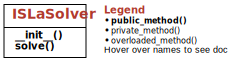

In [51]:
# ignore
with warnings.catch_warnings():
    warnings.simplefilter("default")

    from ClassDiagram import display_class_hierarchy
    hierarchy = display_class_hierarchy([ISLaSolver],
                           public_methods=[
                                ISLaSolver.__init__,
                                ISLaSolver.solve,
                            ])
hierarchy

* FIXME: Have docstrings for publicly available methods
* FIXME: Have a docstring for the `ISLaSolver` class
* FIXME: How do I check a given string whether it satisfies constraints? (Likely `isla.evaluator.evaluate(constraint, tree, grammar)`)

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [52]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [53]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_